<a href="https://colab.research.google.com/github/colaquafina/Roller-King/blob/main/decoding_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context('poster')

from glob import glob

from sklearn import linear_model # linear - GLM
from sklearn.svm import LinearSVC # linear SVM classifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit,cross_validate
from sklearn.svm import SVC
import torch
from torch import nn
from torch import optim
from torch import Tensor
from torch.optim import SGD
import matplotlib as mpl



# Load data

In [2]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

if not os.path.exists('Roller-King'):
    !git clone https://github.com/colaquafina/Roller-King.git

Cloning into 'Roller-King'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 82 (delta 40), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (82/82), done.


# Load manual labels

In [3]:
for item in np.sort(glob('Roller-King/judge_*.npy')):
    print(item.split('/')[-1],np.load(item).shape)

judge_1.npy (440,)
judge_2.npy (440,)
judge_3.npy (440,)
judge_4.npy (430,)


# Combine the manually labeled labels to an array (n_samples,)

In [4]:
manual_labels = np.concatenate([np.load(item) for item in np.sort(glob('Roller-King/judge_*.npy'))])

# Checking the number of voxels of each ROI

In [5]:
unique_roi_index = np.unique(dat['roi'])
unique_roi_names = ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'Laterial occipital']
for idx,name in zip(unique_roi_index,unique_roi_names):
    print(name,np.sum(dat['roi'] == idx))

V1 1294
V2 2083
V3 1790
V3A 484
V3B 314
V4 1535
Laterial occipital 928


In [6]:
print(dat['responses_test'].shape)

(120, 8428)


# Define a function for the decoding pipeline/workflow

In [7]:
def decoding_pipeline(BOLD_signal_voxels,
                      manual_labels,
                      the_model,
                      cv_method,
                      n_splits = 100,
                      **kwarg_cv):
    """
    BOLD_signal_voxels: (n_samples,n_features), the BOLD signals/voxel values
    manual_labels: (n_samples,), the labels that were manually labeled
    the_model: sklearn.pipeline or sklearn.object models, whichever contains methods of .fit and .predict
    cv_method: sklearn.model_selection objects, the cross validation spliter
    n_splits: int, the number of cross validation folds. The higher number of CV folds, the longer time it takes for running
    **kwarg_cv: dict, extra parameters of the cross validation method function
    """
    cv = cv_method(n_splits = n_splits,**kwarg_cv)
    decoding_results = cross_validate(the_model,
                                      BOLD_signal_voxels,
                                      manual_labels,
                                      groups = None,
                                      scoring = 'roc_auc',#什么意思？ # https://en.wikipedia.org/wiki/Receiver_operating_characteristic
                                      cv = cv,
                                      n_jobs = -1,
                                      return_estimator = True,
                                      verbose = 1,
                                      )
    return decoding_results#得到的是什么？ 得到一dictionary的变量，里面包含拟合的方程和每一次cross-validation的测试结果

In [8]:
model_candidates = {'Logistic Regression': make_pipeline(StandardScaler(),
                                                         linear_model.LogisticRegression(class_weight = 'balanced',
                                                                                         random_state = 12345)),
                    'Linear SVM': make_pipeline(StandardScaler(),
                                                LinearSVC(penalty = 'l1', # not default
                                                          loss = 'squared_hinge',
                                                          dual = False, # not default, it has to be False for L1 penalty
                                                          tol = 1e-4,
                                                          C = 1.,
                                                          class_weight = 'balanced',
                                                          random_state = 12345,))}
cv = StratifiedShuffleSplit
results = dict(model_name = [],
               roi_name = [],
               roc_auc = [],
               )
for model_name,model in model_candidates.items():
    res = decoding_pipeline(dat['responses'],
                            manual_labels,
                            the_model = model,
                            cv_method = cv,
                            n_splits = 50,
                            **dict(test_size = 0.2,
                                   random_state = 12345),
                            )
    for item in res['test_score']:
        results['model_name'].append(model_name)
        results['roi_name'].append('All')
        results['roc_auc'].append(item)
    for roi_name,idx_voxel in zip(unique_roi_names,unique_roi_index):
        voxel_selected = dat['responses'][:,dat['roi'] == idx_voxel]
        res = decoding_pipeline(dat['responses'],
                            manual_labels,
                            the_model = model,
                            cv_method = cv,
                            n_splits = 50,
                            **dict(test_size = 0.2,
                                   random_state = 12345),
                            )
        for item in res['test_score']:
            results['model_name'].append(model_name)
            results['roi_name'].append(roi_name)
            results['roc_auc'].append(item)
results = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Don

[(0.45, 0.55),
 Text(23.38145601851852, 0.5, 'ROC AUC'),
 Text(0.5, 6.800000000000004, 'ROI')]

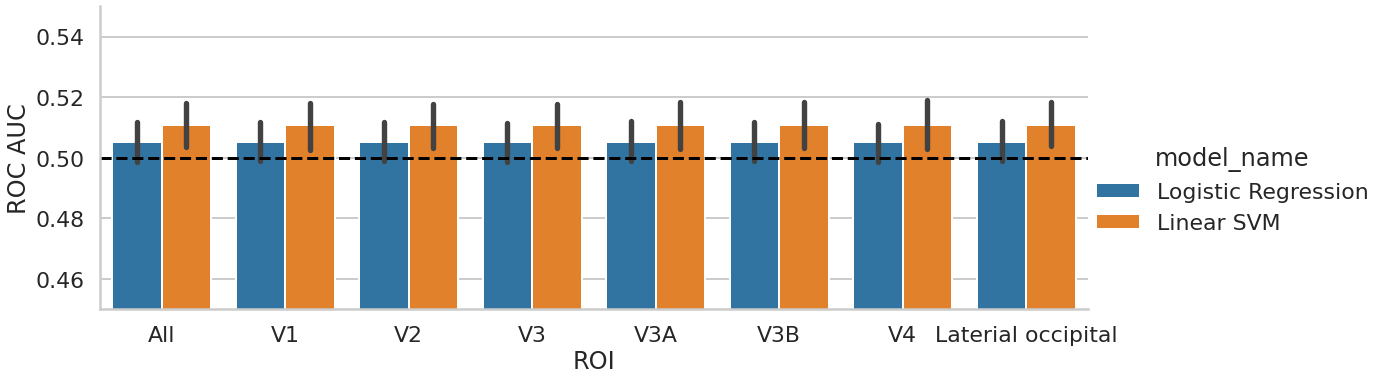

In [14]:

g = sns.catplot(x = 'roi_name',
                 y = 'roc_auc',
                 hue = 'model_name',
                 data = results,
                 kind = 'bar',
                 aspect = 3,)
ax = g.axes.flatten()[0]
ax.axhline(0.5, linestyle = '--',color = 'black',label = 'chance level')
ax.set(ylim = (0.45,0.55),
       xlabel = 'ROI',
       ylabel = 'ROC AUC')

### **try SVM**

In [ ]:
results=dict()
the_model=make_pipeline(StandardScaler(),SVC(kernel='poly',C=1000))
cv=StratifiedShuffleSplit
res=decoding_pipeline(dat['responses'],manual_labels,the_model=the_model,cv_method=cv,n_splits=50,**dict(test_size=0.2,random_state=12345))
results['All']=res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.3min finished


In [ ]:
the_model=make_pipeline(StandardScaler(),SVC(kernel='poly',C=1000))
the_model.fit(dat['responses'][:800],manual_labels[:800])


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='poly', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

# **Try DeepNet**

In [ ]:
class DeepNetSoftmax(nn.Module):
  def __init__(self, n_inputs, n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,n_hidden_5,n_hidden_6,n_hidden_7):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer_1 = nn.Linear(n_inputs, n_hidden_1)  # neural activity --> hidden units
    self.in_layer_2 = nn.Linear(n_hidden_1, n_hidden_2) 
    self.in_layer_3 = nn.Linear(n_hidden_2, n_hidden_3)
    self.in_layer_4 = nn.Linear(n_hidden_3, n_hidden_4)
    self.in_layer_5 = nn.Linear(n_hidden_4, n_hidden_5)
    self.in_layer_6 = nn.Linear(n_hidden_5, n_hidden_6)
    self.in_layer_7 = nn.Linear(n_hidden_6, n_hidden_7) 
    self.out_layer = nn.Linear(n_hidden_7, 2)  # hidden units --> outputs
    self.logprob = nn.Softmax(dim=1)  # probabilities across columns should sum to 1 (each output row corresponds to a different input)

  def forward(self, r):
    h_1 = self.in_layer_1(r)
    h_2 = self.in_layer_2(h_1)
    h_3 = self.in_layer_3(h_2)
    h_4 = self.in_layer_4(h_3)
    h_5 = self.in_layer_5(h_4)
    h_6 = self.in_layer_6(h_5)
    h_7 = self.in_layer_7(h_6)
    logp = self.logprob(self.out_layer(h_7))
    return logp

In [ ]:
def train(net,loss_fn,train_data,train_labels,n_iter=50,learning_rate=0.001,test_data=None,test_labels=None,L2_penalty=0,L1_penalty=0):
    optimizer=optim.SGD(net.parameters(),lr=learning_rate)#这个是SDG是一种gradient decent的方法
    train_loss=[]
    test_loss=[]
    train_labels=train_labels.float()
    train_data=train_data.float()
    # print(train_labels)
    train_labels=torch.hstack([train_labels,1-train_labels])
    ?print(train_labels)
    for i in range(0,50): #这个range是你下降的次数
        out=net(train_data)
        ?print(out.shape,train_data.shape)
      
        loss=loss_fn(out,train_labels)
        optimizer.zero_grad()#这个的意思是每次求新的gradient之前把旧的清空
        loss.backward()#开始gradient
        optimizer.step()#更新参数
        train_loss.append(loss.item())
        if test_data is not None:
            out_test=net(test_data)
            if L2_penalty==0 and L1_penalty==0:
        # normal loss function
              loss_test = loss_fn(out_test, test_labels)
            else:
        # (BONUS code) custom loss function from Bonus exercise 3.3
              loss_test = loss_fn(out_test, test_labels,net.in_layer.weight,
                            L2_penalty, L1_penalty)
            test_loss.append(loss_test.item())
    return train_loss

In [ ]:
manual_labels=manual_labels.reshape(1750,1)
#print(manual_labels[:30])
print(torch.from_numpy(manual_labels[:400]).shape,
torch.from_numpy(dat['responses'][:400]).shape)
print(manual_labels)
print(torch.hstack([torch.from_numpy(manual_labels),torch.from_numpy(1-manual_labels)]))

[0.6930800676345825, 0.6930538415908813, 0.6930275559425354, 0.693001389503479, 0.6929751038551331, 0.6929489970207214, 0.6929227709770203, 0.6928966045379639, 0.6928703188896179, 0.6928441524505615, 0.6928180456161499, 0.6927918791770935, 0.6927656531333923, 0.6927396655082703, 0.6927134990692139, 0.6926873922348022, 0.6926612257957458, 0.6926351189613342, 0.6926089525222778, 0.692582905292511, 0.6925567388534546, 0.6925307512283325, 0.6925046443939209, 0.6924786567687988, 0.6924525499343872, 0.6924265027046204, 0.6924004554748535, 0.6923744082450867, 0.6923484206199646, 0.6923223733901978, 0.6922964453697205, 0.6922704577445984, 0.6922444701194763, 0.6922184228897095, 0.6921924352645874, 0.6921663880348206, 0.6921404004096985, 0.6921144723892212, 0.6920885443687439, 0.6920625567436218, 0.6920366883277893, 0.6920106410980225, 0.6919847726821899, 0.6919587850570679, 0.6919329166412354, 0.6919069886207581, 0.691881000995636, 0.6918551921844482, 0.6918293237686157, 0.6918033361434937]


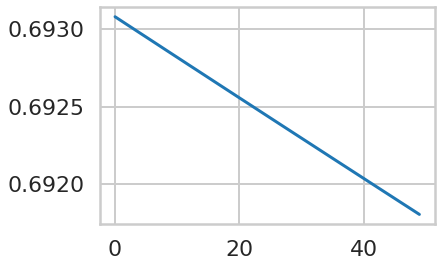

In [ ]:
net = DeepNetSoftmax(8428,4000,2000,1000,500,200,100,50)
loss_fn=nn.BCELoss()
train_loss=train(net,loss_fn,torch.from_numpy(dat['responses'][:100]),torch.from_numpy(manual_labels)[:100])
plt.plot(train_loss)
print(train_loss)

In [ ]:
for i in range(100,120):
  print(net(torch.from_numpy(dat['responses']).float())[i],manual_labels[i])

tensor([0.5491, 0.4509], grad_fn=<SelectBackward>) [1.]
tensor([0.5477, 0.4523], grad_fn=<SelectBackward>) [1.]
tensor([0.5504, 0.4496], grad_fn=<SelectBackward>) [1.]
tensor([0.5463, 0.4537], grad_fn=<SelectBackward>) [1.]
tensor([0.5436, 0.4564], grad_fn=<SelectBackward>) [0.]
tensor([0.5454, 0.4546], grad_fn=<SelectBackward>) [0.]
tensor([0.5463, 0.4537], grad_fn=<SelectBackward>) [1.]
tensor([0.5423, 0.4577], grad_fn=<SelectBackward>) [0.]
tensor([0.5480, 0.4520], grad_fn=<SelectBackward>) [0.]
tensor([0.5425, 0.4575], grad_fn=<SelectBackward>) [0.]
tensor([0.5443, 0.4557], grad_fn=<SelectBackward>) [1.]
tensor([0.5469, 0.4531], grad_fn=<SelectBackward>) [0.]
tensor([0.5462, 0.4538], grad_fn=<SelectBackward>) [0.]
tensor([0.5451, 0.4549], grad_fn=<SelectBackward>) [0.]
tensor([0.5462, 0.4538], grad_fn=<SelectBackward>) [1.]
tensor([0.5498, 0.4502], grad_fn=<SelectBackward>) [1.]
tensor([0.5473, 0.4527], grad_fn=<SelectBackward>) [0.]
tensor([0.5452, 0.4548], grad_fn=<SelectBackward

# Now run the decoding pipeline for various size of the brain

In [ ]:
results = dict()
# decode using all the voxels
## this is a GLM - logistic
#the_model = make_pipeline(StandardScaler(),
#                          linear_model.LogisticRegression(class_weight = 'balanced',
#                                                          random_state = 12345,
#                                                          ))
## this is an SVM - linear SVM
# the_model = make_pipeline(StandardScaler(),
#                           LinearSVC(penalty = 'l1', # not default
#                                     loss = 'squared_hinge',
#                                     dual = False, # not default, it has to be False for L1 penalty
#                                     tol = 1e-4,
#                                     C = 1.,
#                                     class_weight = 'balanced',
#                                     random_state = 12345,
#                                     ))
# cv = StratifiedShuffleSplit
# res = decoding_pipeline(dat['responses'],
#                         manual_labels,
#                         the_model = the_model,
#                         cv_method = cv,
#                         n_splits = 50,
#                         **dict(test_size = 0.2,
#                                random_state = 12345),
#                         )
# results['All'] = res
# for roi_name,idx_voxel in zip(unique_roi_names,unique_roi_index):
#     voxel_selected = dat['responses'][:,dat['roi'] == idx_voxel]
#     the_model = make_pipeline(StandardScaler(),
#                               linear_model.LogisticRegression(class_weight = 'balanced',
#                                                               random_state = 12345,
#                                                               ))
#     results[roi_name] = decoding_pipeline(voxel_selected,manual_labels,
#                                           the_model = the_model,
#                                           cv_method = cv,
#                                           n_splits = 50,
#                                           **dict(test_size = 0.2,
#                                                  random_state = 12345),)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Don

In [ ]:
df_plot = dict(roi_name = [],
               roc_auc = [],
               )
for roi_name,res in results.items():
    for score in res['test_score']:
        df_plot['roi_name'].append(roi_name)
        df_plot['roc_auc'].append(score)
df_plot = pd.DataFrame(df_plot)
print(df_plot)

In [ ]:
fig,ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x = 'roi_name',
                 y = 'roc_auc',
                 data = df_plot,
                 ax = ax,
                 )

ax.axhline(0.5, linestyle = '--',color = 'black',label = 'chance level')
ax.set(ylim = (0.4,0.6))
ax.legend(loc = 'upper left')

# representational similarity analysis

In [ ]:
from scipy.spatial import distance

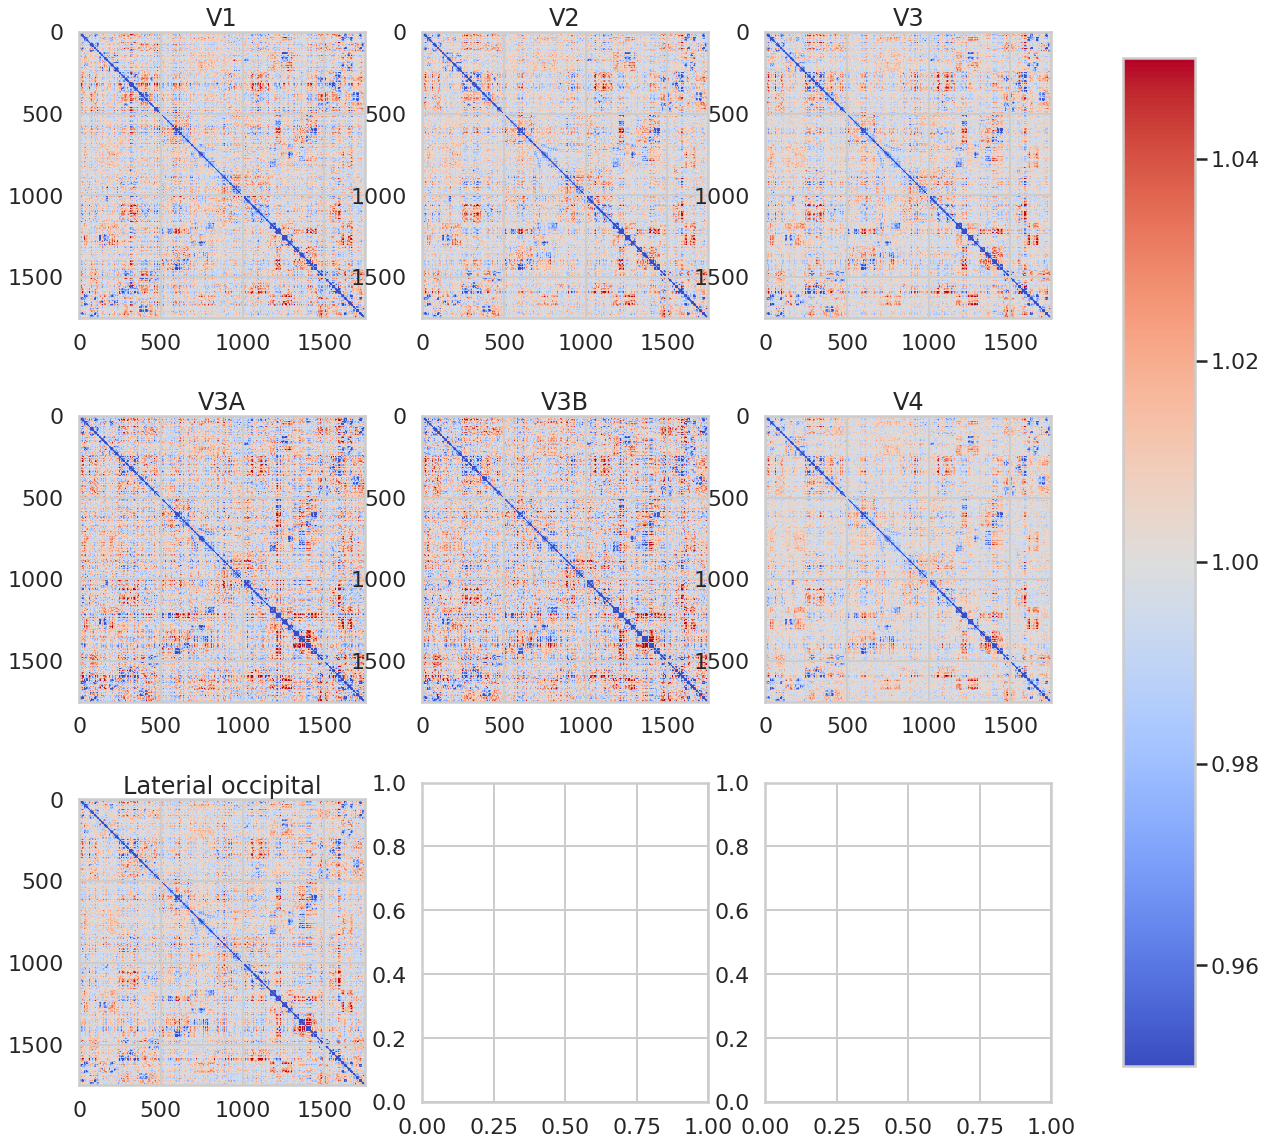

In [ ]:
fig,axes = plt.subplots(figsize = (20,20,),
                        nrows = 3,
                        ncols = 3,
                        )
for roi_name,idx_voxel,ax in zip(unique_roi_names,unique_roi_index,axes.flatten()):
    voxel_selected = dat['responses'][:,dat['roi'] == idx_voxel]
    idx_sort = np.argsort(manual_labels)
    X = voxel_selected[idx_sort]
    y = manual_labels[idx_sort]
    RDM = distance.squareform(distance.pdist(X,metric = 'correlation'))
    im = ax.imshow(RDM,cmap = plt.cm.coolwarm,vmin = .95,vmax = 1.05)
    ax.set(title = roi_name)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)